##  Population-based personalization of a 2D diffusion-based model of myocardial infarct
### Notebook corresponding to our article "Population-based personalization of a 2D diffusion-based model of myocardial infarct", Functional Imaging and Modeling of the Heart (FIMH’25)

This notebook is self-contained to generate large databases with 2D infarcts with the diffusion model.

In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import pickle
import scipy
from scipy.ndimage import convolve
import math

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

Note that the results in the article corresponded to the personalization to real infarct data. For this notebook, we generated synthetic samples using dimensionality reduction (with Isomap) and sampling from the latent space (with multiscale kernel ridge regression as decoder).

### 1. Data preparation

In [4]:
#the size of each infarct image is 80x80
numberPixels = 80

In [5]:
with open("../../data/Data.pkl", "rb") as f:
    realData = pickle.load(f)

We have 100 images in the dataset, we will call it a real population, since it's our basic population used to learn the synthetic population:

In [6]:
print(realData.shape)

(100, 80, 80)


Real coordinates of the grid of a 3D image:

In [7]:
with open("../../data/Coords.pkl", "rb") as f:
    coords = pickle.load(f)

Myocardial contents in 3D:

In [8]:
with open("../../data/Myocardium.pkl", "rb") as f:
    commonMyocardium = pickle.load(f)

In [9]:
tmp1 = np.squeeze(np.sum(realData,0))
myocardiumR = np.logical_not(np.isnan(tmp1))
tmp2 = np.squeeze(commonMyocardium[:,:,5])
imgMyoBool = np.logical_not(np.isnan(tmp2))
imgMyo = imgMyoBool.astype(int)
myocardium = np.multiply(myocardiumR,imgMyoBool)
indMyocardial = np.argwhere(myocardium==1)
validInd = []    
for i in range(1,80):
    for j in range(1,80):
        if imgMyoBool[i,j]==True:
            validInd.append([i,j])
validInd = np.array(validInd)

We represent each image as an 1D array with the content of the myocardium, we will use this representation in the optimization procedure:

In [10]:
def create_XR(data,indMyocardial):
    p = indMyocardial.shape[0]
    nR = data.shape[0]
    XR = np.zeros((p,nR))    
    for i in range(nR):
        tmpR = data[i,:,:]
        for ip in range(p):
            XR[ip,i] = tmpR[indMyocardial[ip,0],indMyocardial[ip,1]]
    return XR
XRAll = create_XR(realData,indMyocardial)
print(XRAll.shape)

(1890, 100)


We use the precomputed division into sectors, 24 angles used to perform the division of the myocardium to sectors:

In [11]:
with open("../../data/imgAngles.pkl", "rb") as f:
    imgAngles = pickle.load(f)

In [12]:
angles = np.unique(imgAngles[np.logical_not(np.isnan(imgAngles))])
print(angles)
print(angles.shape)

[0.041667 0.083333 0.125    0.166667 0.208333 0.25     0.291667 0.333333
 0.375    0.416667 0.458333 0.5      0.541667 0.583333 0.625    0.666667
 0.708333 0.75     0.791667 0.833333 0.875    0.916667 0.958333 1.      ]
(24,)


The size of the biggest infarct in the real dataset corresponded to 16 sectors, thus 16 sectors are used to define the diffusion process:

In [13]:
anglesReduced = np.zeros(17) 
for i in range(11):
    anglesReduced[i]=angles[i]
for i in range(18,24): #21,24
    anglesReduced[i-7]=angles[i]
imgAnglesReduced = np.copy(imgAngles)
for i in range(len(anglesReduced)):
    if i==0:
        left = 0
        right = anglesReduced[i]
    else:
        left = anglesReduced[i-1]
        right = anglesReduced[i]
    imgAnglesReduced[(left<imgAngles)&(imgAngles<=right)] = anglesReduced[i]
anglesReducedWithoutBig = np.delete(anglesReduced,11)

In [14]:
print(anglesReduced)
print(anglesReducedWithoutBig)

[0.041667 0.083333 0.125    0.166667 0.208333 0.25     0.291667 0.333333
 0.375    0.416667 0.458333 0.791667 0.833333 0.875    0.916667 0.958333
 1.      ]
[0.041667 0.083333 0.125    0.166667 0.208333 0.25     0.291667 0.333333
 0.375    0.416667 0.458333 0.833333 0.875    0.916667 0.958333 1.      ]


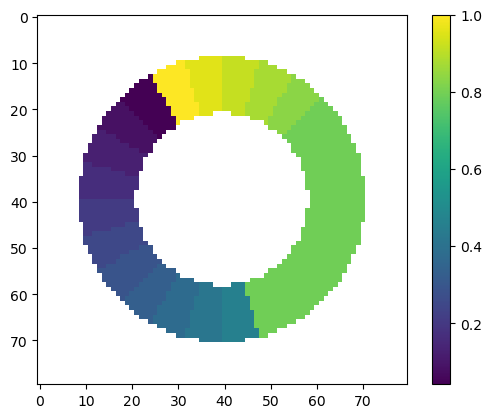

In [15]:
fig, ax = plt.subplots()
shw = ax.imshow(imgAnglesReduced)
bar = plt.colorbar(shw) 
plt.show()

We can find the weighted center of mass. Masses are defined by the average image of the real population. We work with radial and circumferential (angle) coordinates, thus we computed means for them. The mean angle belongs to the sector 2 (counting from 0), we keep the boarder of sectors 2 and 3 as a center of the distribution for the starting zone.

In [16]:
def weighted_center(realData,coords):
    coordr = coords[:,:,5,0]
    coordcirc = coords[:,:,5,1]
    mean = np.squeeze(np.nanmean(realData,axis=0))
    G = np.zeros(2)
    tmp = np.multiply(mean,coordr)
    G[0] = np.nansum(tmp)/np.nansum(mean)
    tmpX = np.multiply(mean,np.cos(coordcirc*2*np.pi))
    tmpY = np.multiply(mean,np.sin(coordcirc*2*np.pi))
    barycenter = np.zeros(2)
    barycenter[0] = np.nansum(tmpX)/np.nansum(mean)
    barycenter[1] = np.nansum(tmpY)/np.nansum(mean)
    alpha = np.arctan2(barycenter[1],barycenter[0])
    G[1] = alpha/(2*np.pi)
    return G

In [17]:
G = weighted_center(realData,coords)
print(G[1])
print(anglesReduced)

0.09954395949769501
[0.041667 0.083333 0.125    0.166667 0.208333 0.25     0.291667 0.333333
 0.375    0.416667 0.458333 0.791667 0.833333 0.875    0.916667 0.958333
 1.      ]


We can define the contour of the endocardium of the potential starting zone:

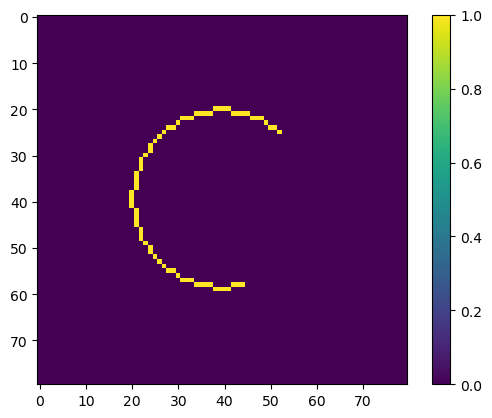

In [18]:
newImgMyo = imgMyo.astype(np.uint8)
contours, hierarchy = cv2.findContours(newImgMyo,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
output = newImgMyo.copy()
outputChannels = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
for s in range(hierarchy.shape[1]):
    if hierarchy[0,s,3]==0:
        indexInner = s
    else:
        indexOuter = s
innerContour = contours[indexInner]
innerContourTotal = []
innerContourUp = []
innerContourDown = []
imgDiffusionPlot = np.zeros_like(imgAngles)
for pixel in range(innerContour.shape[0]):
    if (imgAnglesReduced[innerContour[pixel,0,0],innerContour[pixel,0,1]]>0.8) or (imgAnglesReduced[innerContour[pixel,0,0],innerContour[pixel,0,1]]<0.5):
        r = np.where(anglesReducedWithoutBig==imgAnglesReduced[innerContour[pixel,0,0],innerContour[pixel,0,1]])
        if (imgAnglesReduced[innerContour[pixel,0,0],innerContour[pixel,0,1]]>0.8) or (imgAnglesReduced[innerContour[pixel,0,0],innerContour[pixel,0,1]]<0.15):
            innerContourUp.append([innerContour[pixel,0,0],innerContour[pixel,0,1],r[0][0]])
        else:
            innerContourDown.append([innerContour[pixel,0,0],innerContour[pixel,0,1],r[0][0]])
        imgDiffusionPlot[innerContour[pixel,0,0],innerContour[pixel,0,1]] = 1
        innerContourTotal.append([innerContour[pixel,0,0],innerContour[pixel,0,1],r[0][0]])
innerContourTotal = np.array(innerContourTotal)
innerContourUp = np.array(innerContourUp)
innerContourDown = np.array(innerContourDown)
imgDiffusionPlot = np.array(imgDiffusionPlot)
#to plot the contour
fig, ax = plt.subplots()
shw = ax.imshow(imgDiffusionPlot)
bar = plt.colorbar(shw) 
plt.show()

In [19]:
#to organize sectors
print(innerContourUp.shape)
print(innerContourDown.shape)
innerContourUp = innerContourUp[::-1]
innerContourDownFirst = innerContourDown[:-2]
innerContourDownLast = innerContourDown[-2:]
innerContourDown =  np.vstack((innerContourDownLast,innerContourDownFirst))
upPossibleNumbers = innerContourUp[5:].shape[0]
downPossibleNumbers = innerContourDown[5:].shape[0]
print(upPossibleNumbers)
print(downPossibleNumbers)

(35, 3)
(37, 3)
30
32


We define minimal rectangles. The minimal rectangle of a sector (sometimes called the bounding box of a sector) refers to the smallest axis-aligned rectangle that fully contains the sector.

In [20]:
def rectangles_for_convolution(imgAnglesReduced,anglesReduced,bigSector,numberOfMeaningfulSectors):
    rows, cols = imgAnglesReduced.shape
    validIndMeaningful = []    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if (imgAnglesReduced[i,j]!=anglesReduced[bigSector]) and (not np.isnan(imgAnglesReduced[i,j])):
                validIndMeaningful.append([i,j])
    validIndMeaningful = np.array(validIndMeaningful)

    indSectors = [[] for _ in range(numberOfMeaningfulSectors)]
    for k in range(validIndMeaningful.shape[0]):
        i = validIndMeaningful[k,0]
        j = validIndMeaningful[k,1]
        currentAngle = imgAnglesReduced[i,j]
        r = np.where(anglesReduced==currentAngle)
        if r[0][0]<bigSector:
            indSectors[r[0][0]].append([i,j])
        else:
            indSectors[r[0][0]-1].append([i,j])
    indRectanglesConvolution = []
    for r in range(numberOfMeaningfulSectors):
        currSector = np.array(indSectors[r])
        mini = np.min(currSector[:,0])
        minj = np.min(currSector[:,1])
        maxi = np.max(currSector[:,0])
        maxj = np.max(currSector[:,1])
        indRectanglesConvolution.append([mini,maxi,minj,maxj])
    return indSectors, indRectanglesConvolution, validIndMeaningful

In [21]:
indSectors, indRectanglesConvolution, validIndMeaningful = rectangles_for_convolution(imgAnglesReduced,anglesReduced,11,16)

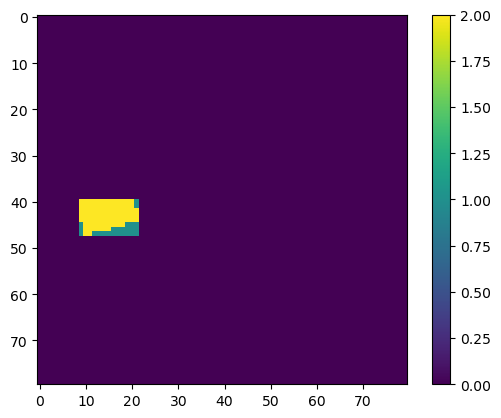

In [22]:
#to test rectangles_for_convolution
imgDiffusionIt = np.zeros_like(imgAngles)
ind = 4
currSector = np.array(indSectors[ind])
mini,maxi,minj,maxj = indRectanglesConvolution[ind]
rows = currSector[:,0]
cols = currSector[:,1]
imgDiffusionIt[rows,cols] = 1
imgDiffusionIt[mini:maxi+1,minj:maxj+1] = imgDiffusionIt[mini:maxi+1,minj:maxj+1]+1
fig, ax = plt.subplots()
shw = ax.imshow(imgDiffusionIt)
bar = plt.colorbar(shw) 
plt.show()

### 2. Generation

In [23]:
#one step of the diffusion propagation defined as a convolution with the specific kernel
def fdm_with_convolution(numberParams,image,imgMyoBool,indRectanglesConvolution,rates):
    avg = np.zeros_like(image)
    for r in range(numberParams):
        #to keep possible rates in the interval [0,10] for the better convergence of CMA-ES
        beta = rates[r]*0.025
        kernel = np.array([[0,beta,0],[beta,1-4*beta,beta],[0,beta,0]])
        mini,maxi,minj,maxj = indRectanglesConvolution[r]
        rectangle = image[mini:maxi+1,minj:maxj+1]
        convolved = convolve(rectangle,kernel,mode='reflect')
        avg[mini:maxi+1,minj:maxj+1] = convolved
    avg[~imgMyoBool] = np.nan
    return avg

In [24]:
#smoothing step applied to the resulting image
def one_smooth_step(image,maskMyo,validInd,radius):
    avg = np.zeros_like(image)
    for k in range(validInd.shape[0]):
        i = validInd[k,0]
        j = validInd[k,1]
        neighborhood = image[i-radius:i+radius+1,j-radius:j+radius+1]
        pixelMask = maskMyo[i-radius:i+radius+1,j-radius:j+radius+1]
        avg[i,j] = np.mean(neighborhood[pixelMask])
    return avg

In [25]:
#generation of the infarct using diffusion steps
def generate_diffusion(params,numberParams,numberCases,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold):
    maxNumIt = params[numberParams+1]
    minNumIt = params[numberParams]
    maxRates = params[:numberParams] #16 sectors
    J = np.zeros((80,80,numberCases))
    numItVal = np.random.randint(minNumIt,maxNumIt+1,size=numberCases)
    startZoneUp = np.random.randint(5,upPossibleNumbers+6,size=numberCases)
    startZoneDown = np.random.randint(5,downPossibleNumbers+6,size=numberCases)
    rates = np.zeros((numberCases,numberParams))
    for r in range(numberParams):
        rates[:,r] = np.random.uniform(0,maxRates[r],size=numberCases)
    for k  in range(numberCases):
        imgDiffusionIt = np.zeros_like(imgAngles)
        for it in range(numItVal[k]):
            imgDiffusionIt[innerContourDown[:startZoneDown[k],0],innerContourDown[:startZoneDown[k],1]] = 1
            imgDiffusionIt[innerContourUp[:startZoneUp[k],0],innerContourUp[:startZoneUp[k],1]] = 1
            imgDiffusionIt = fdm_with_convolution(numberParams,imgDiffusionIt,imgMyoBool,indRectanglesConvolution,rates[k,:]) #maxRates or rates[k,:]
            imgDiffusionIt = np.nan_to_num(imgDiffusionIt)
        imgDiffusionIt = one_smooth_step(imgDiffusionIt,imgMyoBool,validInd,2)
        imgDiffusionIt[imgDiffusionIt<threshold] = 0
        nonZeroMask = ~np.isnan(imgDiffusionIt)&(imgDiffusionIt!=0)
        imgDiffusionIt[nonZeroMask] = 1
        finalImg = imgDiffusionIt+imgMyo
        finalImg[finalImg==0] = np.nan
        J[:,:,k] = finalImg
    return J

In [26]:
threshold = 0.01
params = np.array([7,5,5,5,5,1,1,1,1,1,5,5,7,7,7,7,30,100])
#params = np.array([0.175,0.125,0.125,0.125,0.125,0.025,0.025,0.025,0.025,0.025,0.125,0.125,0.175,0.175,0.175,0.175,30,100])
numberCases = 15
JAll = generate_diffusion(params,16,numberCases,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)

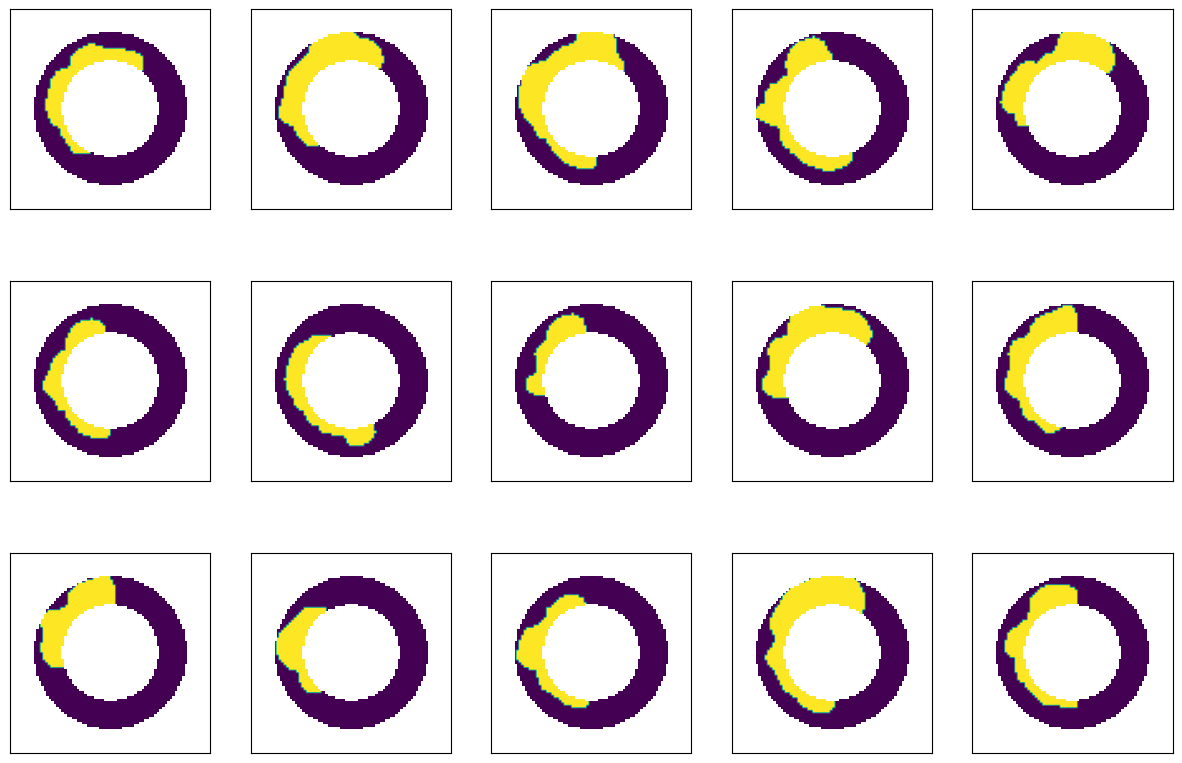

In [27]:
fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(15,10))
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(JAll[:,:,s])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()

### 3. Personalization

In [28]:
def kde(XR,XS,nR,kNN):
    X = np.concatenate((XR,XS),axis=1) #ndim x nbcas
    tmpKS = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X.T))
    tmp = tmpKS+np.diag(math.inf*np.ones(X.shape[1]))
    tmpB = np.sort(tmp,axis=0)
    tmpB = tmpB[kNN,:]
    sigma = np.mean(tmpB)
    K = np.exp(-tmpKS**2/(2*sigma**2))
    pdfXR = np.sum(K[0:nR,:],axis=0)
    pdfXR = pdfXR/(nR*sigma*np.sqrt(2*np.pi))
    pdfXR = pdfXR/np.sum(pdfXR)
    pdfXS = np.sum(K[nR:,:],axis=0)
    pdfXS = pdfXS/((X.shape[1]-nR)*sigma*np.sqrt(2*np.pi))
    pdfXS = pdfXS/np.sum(pdfXS)
    return pdfXR, pdfXS

def loss_function(params,numberParams,numberCases,XR,indMyocardial,knn,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold):    
    J = generate_diffusion(params,numberParams,numberCases,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)
    nR = XR.shape[1]
    nS = numberCases
    p = indMyocardial.shape[0]
    XS = np.zeros((p,nS))
    for i in range(nS):
        tmp = J[:,:,i]
        for ip in range(p):
            XS[ip,i] = tmp[indMyocardial[ip,0],indMyocardial[ip,1]]
    pdfXR, pdfXS = kde(XR,XS,nR,knn)
    KLtmp = np.multiply(pdfXS,np.log(np.divide(pdfXS,pdfXR)))
    L = np.sum(KLtmp) 
    return L

In [29]:
#adapted from the minimalistic Matlab implementation http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaes_inmatlab.html#matlab
def cmaes2D(numberCases,numberParam,xStart,sigmaStart,stopFitness,stopEval,lmbda,XR,indMyocardial,knn,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold):   
    #parameters
    start = time.time()
    xmean = xStart 
    sigma = sigmaStart
    stopfitness = stopFitness  #stop if fitness < stopfitness
    stopeval = stopEval   #stop after stopeval number of function evaluations
    mu = int(np.floor(lmbda/4))
    weights = np.log((lmbda+1)/2)-np.log(np.linspace(1,mu,mu))
    weights = weights/np.sum(weights)
    mueff=np.sum(weights)**2/np.sum(weights**2)
    
    #strategy parameter setting: adaptation
    cc = (4+mueff/numberParam)/(numberParam+4+2*mueff/numberParam)
    cs = (mueff+2)/(numberParam+mueff+5)
    c1 = 2/((numberParam+1.3)**2+mueff)
    cmu = min(1-c1,2*(mueff-2+1/mueff)/((numberParam+2)**2+mueff))
    damps = 1 + 2*max(0,np.sqrt((mueff-1)/(numberParam+1))-1)+cs 
    
    #initialize dynamic (internal) strategy parameters and constants
    pc = np.zeros(numberParam)
    ps = np.zeros(numberParam)
    B = np.eye(numberParam,numberParam)                   
    D = np.ones(numberParam)
    C = B@np.diag(D**2)@B.T
    invsqrtC = B@np.diag(D**(-1))@B.T
    eigeneval = 0
    chiN=numberParam**0.5*(1-1/(4*numberParam)+1/(21*numberParam**2))
    
    #for output
    outdatx = []
    outdata = []
    outsigma = []
    outd = []
    
    #generation loop
    counteval = 0
    while (counteval<stopeval):
        arx = np.zeros((numberParam,lmbda))
        arfitness = np.zeros(lmbda)
        for k in range(lmbda):
            arx[:,k] = xmean+sigma*B@np.multiply(D,np.random.normal(0,1,numberParam))
            nP = numberParam-2
            #rates should be in the interval [0,10]
            while np.any((arx[:-2,k]<0)|(arx[:-2,k]>10)):
                arx[:,k] = xmean+sigma*B@np.multiply(D,np.random.normal(0,1,numberParam))
            arfitness[k] = loss_function(arx[:,k],nP,numberCases,XR,indMyocardial,knn,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)
            counteval = counteval+1

        #sort by fitness and compute weighted mean into xmean
        arindex = np.argsort(arfitness)
        arfitness = np.sort(arfitness)
        xold = xmean
        tmp = np.zeros((numberParam,mu))
        for k in range(mu):
            ind = arindex[k]
            tmp[:,k] = arx[:,ind]
        xmean = tmp@weights  #recombination, new mean value
        
        #cumulation: update evolution paths
        ps = (1-cs)*ps+np.sqrt(cs*(2-cs)*mueff)*invsqrtC@(xmean-xold)/sigma
        hsig = np.sum(ps**2)/(1-(1-cs)**(2*counteval/lmbda))/numberParam < 2+4/(numberParam+1)
        pc = (1-cc)*pc+hsig*np.sqrt(cc*(2-cc)*mueff)*(xmean-xold)/sigma

        #adapt covariance matrix C
        repmatxold = np.zeros(tmp.shape)
        for j in range(tmp.shape[1]):
            repmatxold[:,j] =  xold
        artmp = (1/sigma)*(tmp-repmatxold)
        C = (1-c1-cmu)*C+c1*(pc@pc.T+(1-hsig)*cc*(2-cc)*C)+cmu*artmp@np.diag(weights)@artmp.T

        #adapt step size sigma
        sigma = sigma*np.exp((cs/damps)*(np.linalg.norm(ps)/chiN-1))
        
        #update B and D from C
        if counteval-eigeneval>lmbda/(c1+cmu)/numberParam/10: 
            eigeneval = counteval
            C = np.triu(C) + np.triu(C,1).T
            D, B = np.linalg.eig(C)
            D = np.sqrt(D)
            invsqrtC = B@np.diag(D**(-1))@B.T 

        #break, if fitness is good enough
        if (arfitness[0]<=stopfitness) or (np.max(D)>1e7*np.min(D)):
            print('break1')
            break
            

        outdata.append(arfitness[0])
        outsigma.append(sigma)
        outd.append(D)
        outdatx.append(xmean)
        current = time.time()
        passed = current - start
        print('Passed time: ', passed, ' Function evaluations: ', counteval)
                
                
    #final Message
    print('Parameters : ', xmean)    
    outData = outdata
    outDatx = outdatx
    outSigma = outsigma
    outD = outd
    #lambdaBest = arindex[0]
    params = xmean
    J = generate_diffusion(params,nP,numberCases,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)
    print('Counteval: ', counteval)
    return params, outData, outDatx, outSigma, outD, J, passed

In [30]:
threshold = 0.01
part1 = np.full(16,1)
part2 = np.array([30,100])
xStart = np.concatenate([part1,part2])
nbParam = xStart.shape[0]
sigmaStart = 1
stopFitness = 0.004
nbCases = 40
knn = 9
stopEval = 260
lmbda = 13
xmin, outData, outDatx, outSigma, outD, J, t = cmaes2D(nbCases,nbParam,xStart,sigmaStart,stopFitness,stopEval,lmbda,XRAll,indMyocardial,knn,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)
print('Execution time: ', t)

Passed time:  31.14990258216858  Function evaluations:  13
Passed time:  62.979729413986206  Function evaluations:  26
Passed time:  93.44000053405762  Function evaluations:  39
Passed time:  123.37544870376587  Function evaluations:  52
Passed time:  154.70253777503967  Function evaluations:  65
Passed time:  185.19629168510437  Function evaluations:  78
Passed time:  215.3624186515808  Function evaluations:  91
Passed time:  246.1554524898529  Function evaluations:  104
Passed time:  281.03798747062683  Function evaluations:  117
Passed time:  315.4358239173889  Function evaluations:  130
Passed time:  347.33293056488037  Function evaluations:  143
Passed time:  380.1444489955902  Function evaluations:  156
Passed time:  413.71869134902954  Function evaluations:  169
Passed time:  447.5091452598572  Function evaluations:  182
Passed time:  480.7770104408264  Function evaluations:  195
Passed time:  511.85499358177185  Function evaluations:  208
Passed time:  542.4371938705444  Functi

### 4. Visualization of results

We can observe the decrease of the loss function computed for 40 generated cases for each iteration:

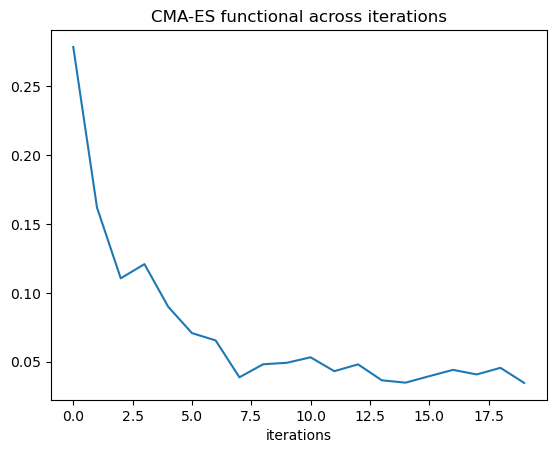

In [31]:
plt.plot(outData)
plt.title("CMA-ES functional across iterations")
plt.xlabel('iterations')
plt.show()

We can plot 40 generated images from the last step of the optimization procedure:

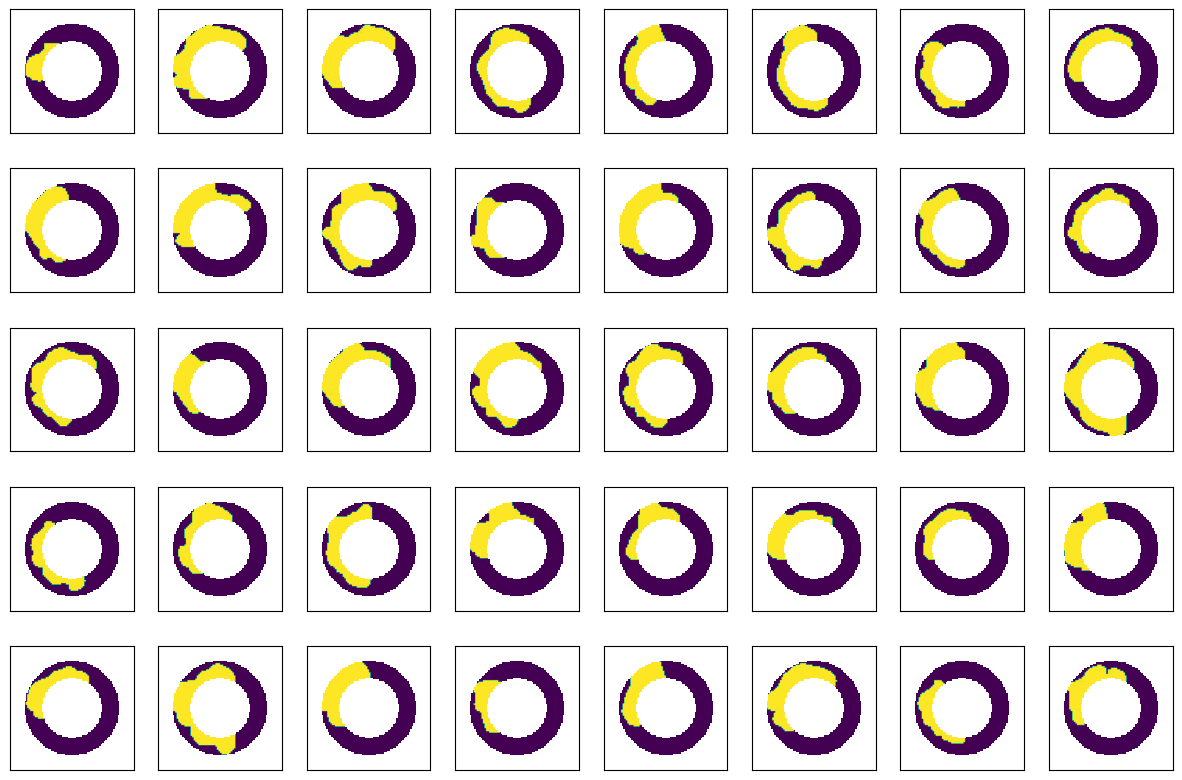

In [32]:
fig, ax = plt.subplots(nrows=5,ncols=8,figsize=(15,10),sharey=True,sharex=True)
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(J[:,:,s])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()

### 4. Generation of a big database

But using the optimized model parameters, we can generate big datasets with infarcts:

In [33]:
NBig = 500
JBig = generate_diffusion(outDatx[-1],16,NBig,innerContourUp,innerContourDown,upPossibleNumbers,downPossibleNumbers,imgMyo,imgMyoBool,imgAngles,validInd,indRectanglesConvolution,threshold)

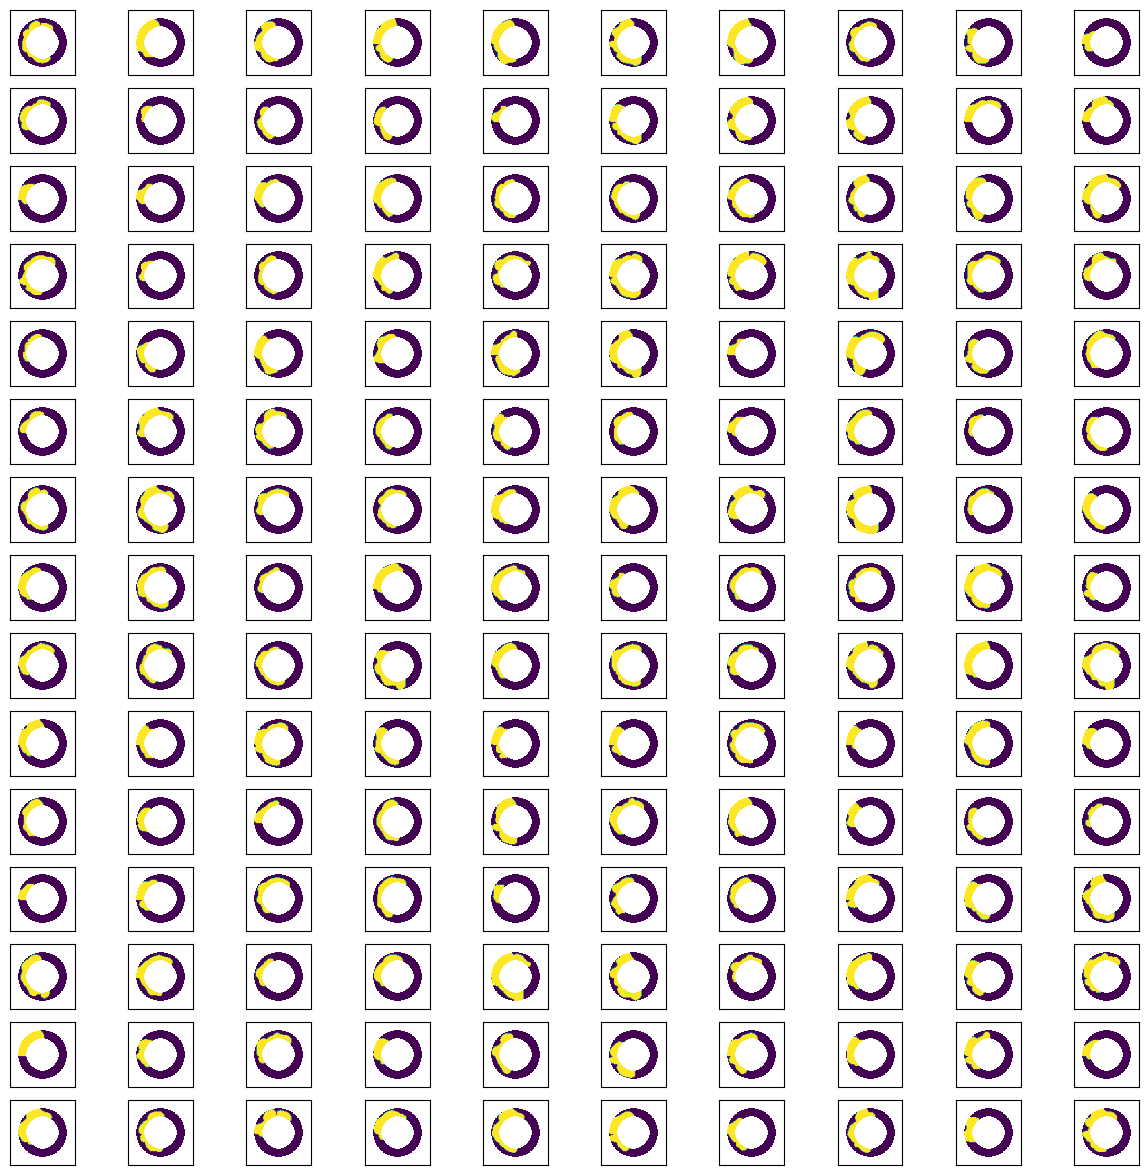

In [34]:
fig, ax = plt.subplots(nrows=15,ncols=10,figsize=(15,15),sharey=True,sharex=True)
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(JBig[:,:,s])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()